In [2]:
import cv2
import numpy as np

def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray.astype(np.float32))
    
    cap.release()
    return np.array(frames)

In [3]:
video_path = "/DATA/home/jgarcia/SpectralSegmentation/mcv-c6-2026-team2/Week 1/Data/AICity_data/train/S03/c010/vdo.avi"
frames = load_video_frames(video_path)

print("Total frames:", len(frames))


N = len(frames)
train_end = int(0.25 * N)

train_frames = frames[:train_end]
test_frames = frames[train_end:]

print("Training frames:", len(train_frames))
print("Testing frames:", len(test_frames))

Total frames: 2141
Training frames: 535
Testing frames: 1606


In [ ]:
train_frames = train_frames.astype(np.float32)
test_frames = test_frames.astype(np.float32)

mu = np.mean(train_frames, axis=0)
sigma = np.std(train_frames, axis=0)

roi = cv2.imread("/DATA/home/jgarcia/SpectralSegmentation/mcv-c6-2026-team2/Week 1/Data/AICity_data/train/S03/c010/roi.jpg", cv2.IMREAD_GRAYSCALE)
roi = roi > 0

alpha = 3
foreground_masks = []

for frame in test_frames:

    diff = np.abs(frame - mu)

    sigma_safe = np.maximum(sigma, 1e-6)
    mask = diff >= alpha * (sigma_safe + 2)

    mask = mask & roi
    mask = mask.astype(np.uint8) * 255

    foreground_masks.append(mask)

In [30]:
kernel = np.ones((7, 7), np.uint8)
foreground_masks = []

for frame in test_frames:

    diff = np.abs(frame - mu)

    sigma_safe = np.maximum(sigma, 1e-6)
    mask = diff >= alpha * (sigma_safe + 2)

    mask = mask & roi
    mask = mask.astype(np.uint8) * 255

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    foreground_masks.append(mask)

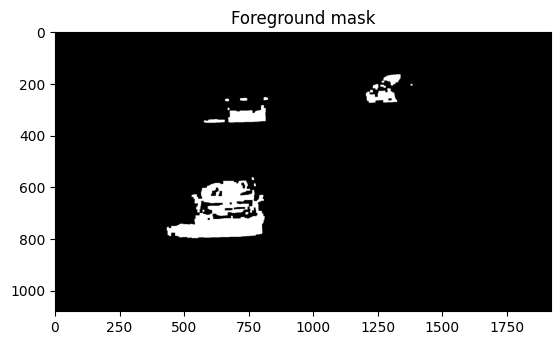

In [31]:
import matplotlib.pyplot as plt

plt.imshow(foreground_masks[10], cmap="gray")
plt.title("Foreground mask")
plt.show()

In [32]:
detections_per_frame = []

for frame in test_frames:

    diff = np.abs(frame - mu)

    sigma_safe = np.maximum(sigma, 1e-6)
    mask = diff >= alpha * (sigma_safe + 2)

    mask = mask & roi
    mask = mask.astype(np.uint8) * 255

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    foreground_masks.append(mask)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    frame_bboxes = []

    for i in range(1, num_labels):  # skip background (label 0)
        x, y, w, h, area = stats[i]

        if area > 150:   # filter small noise (you can tune this)
            frame_bboxes.append([x, y, x+w, y+h])

    detections_per_frame.append(frame_bboxes)

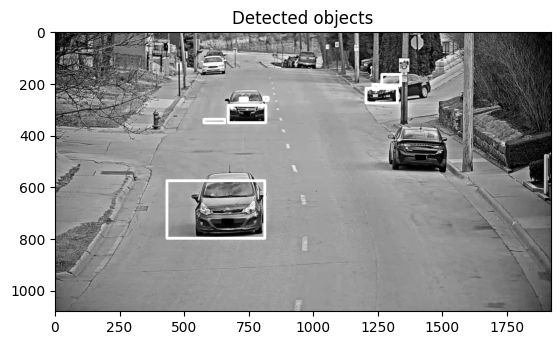

In [37]:
import matplotlib.pyplot as plt

frame_id = 10

frame = test_frames[frame_id].astype(np.uint8)
bboxes = detections_per_frame[frame_id]

for box in bboxes:
    x1, y1, x2, y2 = box
    cv2.rectangle(frame, (x1,y1), (x2,y2), (255,0,0), 10)

plt.imshow(frame, cmap="gray")
plt.title("Detected objects")
plt.show()